In [5]:
import optuna

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, KFold

In [6]:
train = pd.read_parquet("train_data.pqt")
test = pd.read_parquet("test_data.pqt")

cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]

train[cat_cols] = train[cat_cols].astype("category")
test[cat_cols] = test[cat_cols].astype("category")

In [7]:
class CatFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, replace_nan=True):
        self.cat_cols = ["city", "city_type", "index_city_code",
                         "okved", "segment", "start_cluster", "channel_code",
                         "ogrn_month", "ogrn_year"]
        self.replace_nan = replace_nan
        
    def fit(self, train):
        categories = ['city', 'city_type', 'index_city_code']
        objects = [list(train[cat].value_counts()[:255].keys()) for cat in categories]
        self.d = {key: value for key, value in zip(categories, objects)}
        return self

    def transform(self, df):
        df = df.copy()
        
        if self.replace_nan:
            for cat in self.cat_cols:
                df[cat] = df[cat].cat.add_categories('no data').fillna('no data')
            for index in self.d:
                self.d[index].append('no data')
        
        for cat in ['city', 'city_type', 'index_city_code']:
            df[cat] = df[cat].cat.add_categories(['other'])
            df[cat][~df[cat].isin(self.d[cat])] = 'other'
            df[cat] = df[cat].cat.remove_unused_categories()
        
        cat_change = ['okved', 'segment', 'channel_code', 'city', 'city_type', 'index_city_code', 'start_cluster']
        saved_value = {}
        for cat in cat_change:
            df[cat + '_past_1'] = 'no data'
            df[cat + '_past_2'] = 'no data'
            df[cat + '_change'] = False
            if cat != 'start_cluster':
                df[cat + '_change_nan'] = False
        for i, row in tqdm(df.iterrows()):
            if (i == 0) or (df['id'][i] != df['id'][i - 1]):
                for cat in cat_change:
                    saved_value[cat] = row[cat]
            else:
                for cat in cat_change:
                    if saved_value[cat] is not row[cat]:
                        df.loc[i, cat + '_change'] = True
                        if (cat != 'start_cluster') and df[cat].isna()[i]:
                            df.loc[i, cat + '_change_nan'] = True
                for cat in cat_change:
                    saved_value[cat] = row[cat]
            if int(df['date'][i][6]) % 3 == 0:
                for cat in cat_change:
                    df.loc[i, cat + '_past_1'] = df[cat][i - 1]
                    if int(df['date'][i - 2][6]) % 3 == 1:
                        df.loc[i, cat + '_past_2'] = df[cat][i - 2]
        for cat in cat_change:
            df[cat + '_past_1'] = df[cat + '_past_1'].astype('category')
            df[cat + '_past_2'] = df[cat + '_past_2'].astype('category')
        
        return df

In [8]:
tr = CatFeatures()
train = tr.fit_transform(train)
test = tr.transform(test)
train = train.fillna(-100000)
test = test.fillna(-100000)

In [9]:
train_three_month = train[train['date'] == 'month_3']
train_two_month = train[train['date'] == 'month_3']

id_three_month = []
id_two_month = []
for i, row in test.iterrows():
    if (row['date'] == 'month_6') and (test['date'][i-1] == 'month_5') and (test['date'][i-2] == 'month_4'):
        id_three_month.append(row['id'])
    elif row['date'] == 'month_6':
        id_two_month.append(row['id'])
    if row['date'] == 'month_6':
        test.loc[i, 'start_cluster'] = test.loc[i - 1, 'start_cluster']
        
test_three_month = test[(test['date'] == 'month_6') & test['id'].isin(id_three_month)]
test_two_month = test[(test['date'] == 'month_6') & test['id'].isin(id_two_month)]

train_two_month = train_two_month.drop(['okved_past_2', 'segment_past_2', 'channel_code_past_2', 'city_past_2', 'city_type_past_2', 'index_city_code_past_2', 'start_cluster_past_2'], axis=1)
test_two_month = test_two_month.drop(['okved_past_2', 'segment_past_2', 'channel_code_past_2', 'city_past_2', 'city_type_past_2', 'index_city_code_past_2', 'start_cluster_past_2'], axis=1)
train_two_month = train_two_month[train_two_month['start_cluster'].isin(['{}', '{α}', '{other}', '{α, η}', '{α, γ}', '{α, λ}', '{α, ψ}'])]

In [10]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

cluster_weights = pd.read_excel("cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [11]:
y_pred_three_month = None
for j in tqdm(range(3)):
    model = LGBMClassifier(is_unbalance=True, force_row_wise=True, seed=j, **{'objective': 'multiclass', 'n_estimators': 700, 'learning_rate': 0.010508425284147416, 'max_depth': 5, 'max_cat_threshold': 8, 'cat_l2': 33.58597515117446})
    model.fit(train_three_month.drop(['id', 'date', 'end_cluster'], axis=1), train_three_month['end_cluster'])
    if y_pred_three_month is None:
        y_pred_three_month = model.predict_proba(test_three_month.drop(['id', 'date'], axis=1))
    else:
        y_pred_three_month += model.predict_proba(test_three_month.drop(['id', 'date'], axis=1))
y_pred_three_month = y_pred_three_month / 3

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [12:54<00:00, 258.18s/it]


In [ ]:
y_pred_two_month = None
for j in tqdm(range(3)):
    model = LGBMClassifier(is_unbalance=True, force_row_wise=True, seed=j, **{'objective': 'multiclass', 'n_estimators': 700, 'learning_rate': 0.010508425284147416, 'max_depth': 5, 'max_cat_threshold': 8, 'cat_l2': 33.58597515117446})
    model.fit(train_two_month.drop(['id', 'date', 'end_cluster'], axis=1), train_two_month['end_cluster'])
    if y_pred_two_month is None:
        y_pred_two_month = model.predict_proba(test_two_month.drop(['id', 'date'], axis=1))
    else:
        y_pred_two_month += model.predict_proba(test_two_month.drop(['id', 'date'], axis=1))
y_pred_two_month = y_pred_two_month / 3

In [ ]:
sample_submission_df = pd.read_csv("sample_submission.csv")
columns = model.classes_
sample_submission_df.loc[sample_submission_df['id'].isin(id_three_month), columns] = y_pred_three_month
sample_submission_df.loc[sample_submission_df['id'].isin(id_two_month), columns] = y_pred_two_month

sorted_classes = sorted(sample_submission_df.columns.to_list())
test_pred_proba_df = sample_submission_df[sorted_classes]
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("submission_seed.csv", index=False)

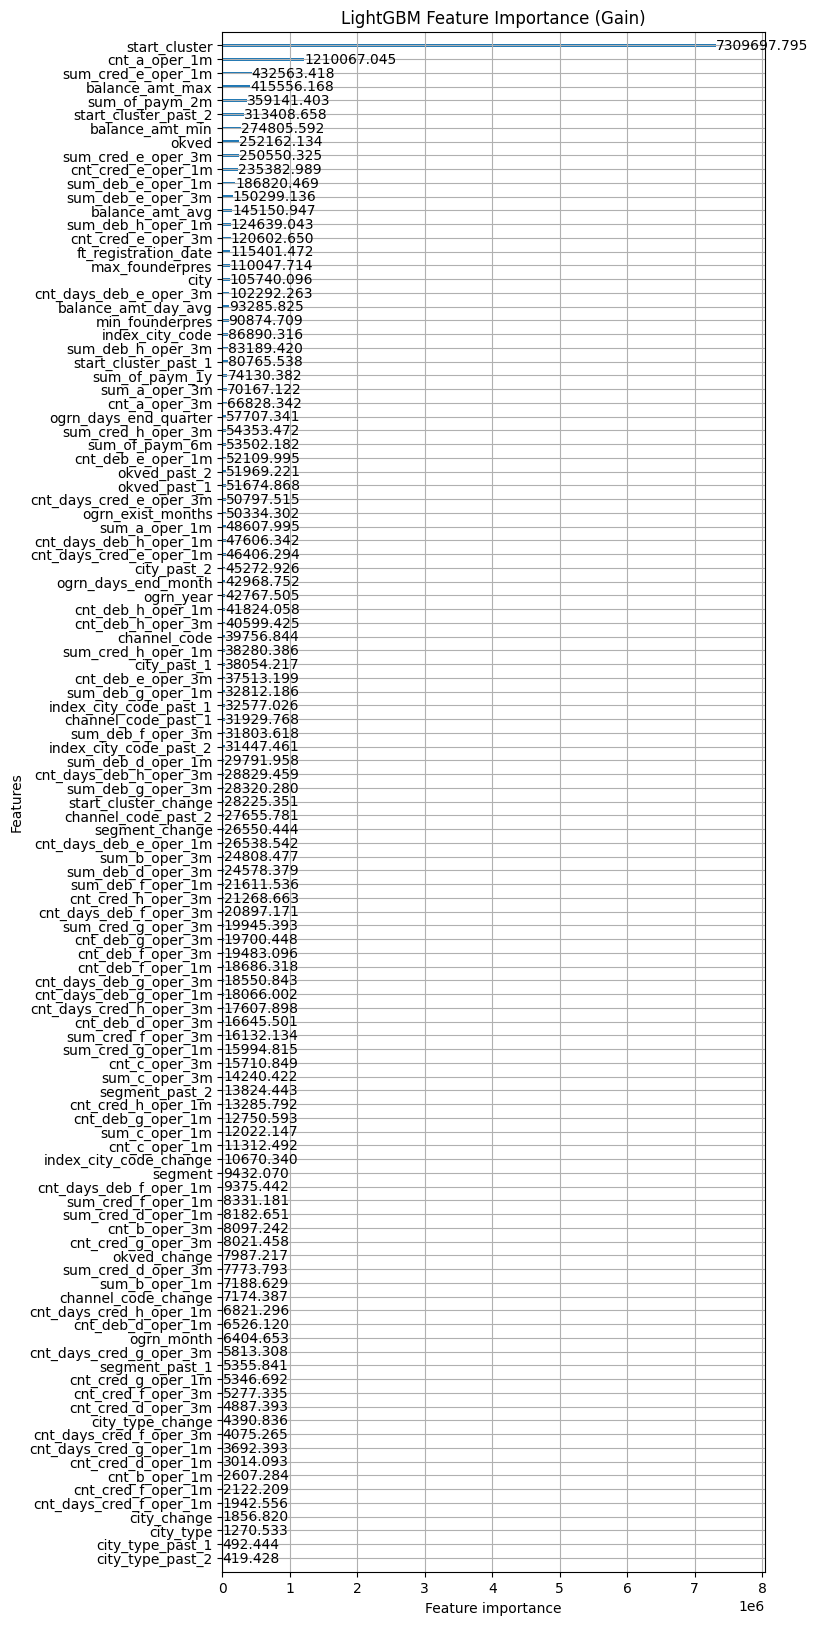

In [12]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,20), title="LightGBM Feature Importance (Gain)")
plt.show()